### 导入库

In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

### 导入数据集

In [2]:
def load_dataset():
#训练集
    train_dataset = h5py.File('train_cifar10.h5', "r")
    train_set_x_orig = np.array(train_dataset["X_train"][:])
    train_set_y_orig = np.array(train_dataset["y_train"][:])
    
#测试集
    test_dataset = h5py.File('test_cifar10.h5', "r")
    test_set_x_orig = np.array(test_dataset["X_test"][:])
    test_set_y_orig = np.array(test_dataset["y_test"][:])

    classes = np.array(test_dataset["classes_list"][:])
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

### 将数据集转换为矢量

In [4]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

### 数据标准化

In [5]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [6]:
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)

(50, 591, 260, 3)
(1, 50)
(18, 591, 260, 3)
(1, 18)
(2,)


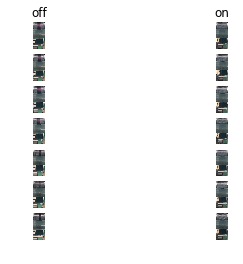

In [7]:
list_classes = []
for i in range(2):
    list_classes.append(classes[i].decode('utf-8'))
num_classes = len(list_classes)
num_each_class = 7
for y, cls in enumerate(list_classes):
    idxs = np.flatnonzero( train_set_y == y)
    idxs = np.random.choice(idxs, num_each_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + (y + 1)
        plt.subplot(num_each_class, num_classes, plt_idx)
        plt.imshow(train_set_x_orig[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### 计算欧氏距离

In [8]:
def distance(X_test, X_train):
    
    num_test = X_test.shape[1]
    num_train = X_train.shape[1]
    distances = np.zeros((num_test, num_train))
    dist1 = np.multiply(np.dot(X_test.T,X_train), -2)    # -2X_test*X_train, shape (num_test, num_train)
    dist2 = np.sum(np.square(X_test.T), axis=1, keepdims=True)    # X_test*X_test, shape (num_test, 1)
    dist3 = np.sum(np.square(X_train), axis=0,keepdims=True)    # X_train*X_train, shape(1, num_train)
    distances = np.sqrt(dist1 + dist2 + dist3)

    return distances

### 定义预测函数

In [9]:
def predict(X_test, X_train, Y_train, k = 1):

    distances = distance(X_test, X_train)
    num_test = X_test.shape[1]
    Y_prediction = np.zeros(num_test)
    for i in range(num_test):
        dists_min_k = np.argsort(distances[i])[:k]     # 按照距离递增次序进行排序,选取距离最小的k个点 
        y_labels_k = Y_train[0,dists_min_k]     # 确定前k个点的所在类别
        Y_prediction[i] = np.argmax(np.bincount(y_labels_k)) # 返回前k个点中出现频率最高的类别作为测试数据的预测分类

    return Y_prediction, distances

### 定义模型

In [10]:
def model(X_test, Y_test, X_train, Y_train, k = 1, print_correct = False):
  
    Y_prediction, distances = predict(X_test, X_train, Y_train, k)
    num_correct = np.sum(Y_prediction == Y_test)
    accuracy = np.mean(Y_prediction == Y_test)
    if print_correct:
        print('Correct %d/%d: The test accuracy: %f' % (num_correct, X_test.shape[1], accuracy))
    d = {"k": k,
         "Y_prediction": Y_prediction, 
         "distances" : distances,
         "accuracy": accuracy}
    return d

### 测试模型

In [11]:
d = model(test_set_x, test_set_y,train_set_x, train_set_y, k=1, print_correct = True)

Correct 18/18: The test accuracy: 1.000000


y = 1, you predicted that it is a "on" picture.


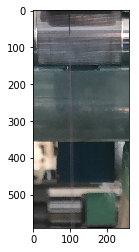

In [12]:
num_px = train_set_x_orig.shape[1]
index = 1
plt.imshow(test_set_x[:,index].reshape((591,260, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction"][index])].decode('utf-8') +  "\" picture.")